In [1]:
!pip install --upgrade -q git+https://github.com/MaxHalford/xam optuna

In [2]:
train_path = "../input/house-prices-advanced-regression-techniques/train.csv"
test_path = "../input/house-prices-advanced-regression-techniques/test.csv"

train_path_rf = "../input/imputedhousepricedata/train.csv"
test_path_rf = "../input/imputedhousepricedata/test.csv"

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from IPython.display import display
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
import optuna
from sklearn.linear_model import Lasso, Ridge
from sklearn.svm import SVR
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.preprocessing import StandardScaler
from xam.feature_extraction import BayesianTargetEncoder

In [4]:
# import train, test data
X = pd.read_csv(train_path, index_col='Id')
X_test_full = pd.read_csv(test_path, index_col='Id')

X_rf = pd.read_csv(train_path_rf)
X_rf.columns = ['Id'] + list(X_rf.columns)[1:]
X_rf.set_index('Id', inplace=True)

X_test_full_rf = pd.read_csv(test_path_rf)
X_test_full_rf.columns = ['Id'] + list(X_test_full_rf.columns)[1:]
X_test_full_rf.set_index('Id', inplace=True)

display(X.head())
display(X_rf.head())
display(X_test_full.head())
display(X_test_full_rf.head())

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
Id,,,,,,,,,,,,,,,,,,,,,
1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
Id,,,,,,,,,,,,,,,,,,,,,
1,60,RL,65.0,8450,Pave,None,Reg,Lvl,AllPub,Inside,...,0,None,None,None,0,2,2008,WD,Normal,208500
2,20,RL,80.0,9600,Pave,None,Reg,Lvl,AllPub,FR2,...,0,None,None,None,0,5,2007,WD,Normal,181500
3,60,RL,68.0,11250,Pave,None,IR1,Lvl,AllPub,Inside,...,0,None,None,None,0,9,2008,WD,Normal,223500
4,70,RL,60.0,9550,Pave,None,IR1,Lvl,AllPub,Corner,...,0,None,None,None,0,2,2006,WD,Abnorml,140000
5,60,RL,84.0,14260,Pave,None,IR1,Lvl,AllPub,FR2,...,0,None,None,None,0,12,2008,WD,Normal,250000


,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
Id,,,,,,,,,,,,,,,,,,,,,
1461,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,Inside,...,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1462,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
1463,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal
1464,60,RL,78.0,9978,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
1465,120,RL,43.0,5005,Pave,NaN,IR1,HLS,AllPub,Inside,...,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal


,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
Id,,,,,,,,,,,,,,,,,,,,,
1461,20,RH,80.0,11622,Pave,None,Reg,Lvl,AllPub,Inside,...,120,0,None,MnPrv,None,0,6,2010,WD,Normal
1462,20,RL,81.0,14267,Pave,None,IR1,Lvl,AllPub,Corner,...,0,0,None,None,Gar2,12500,6,2010,WD,Normal
1463,60,RL,74.0,13830,Pave,None,IR1,Lvl,AllPub,Inside,...,0,0,None,MnPrv,None,0,3,2010,WD,Normal
1464,60,RL,78.0,9978,Pave,None,IR1,Lvl,AllPub,Inside,...,0,0,None,None,None,0,6,2010,WD,Normal
1465,120,RL,43.0,5005,Pave,None,IR1,HLS,AllPub,Inside,...,144,0,None,None,None,0,1,2010,WD,Normal


In [5]:
features = X.drop(columns=['SalePrice'])
target = X['SalePrice']

features_rf = X_rf.drop(columns=['SalePrice'])
target_rf = X_rf['SalePrice']

print(f'data type value count\n{X.dtypes.value_counts()}\n')
print(f'imputed data type value count\n{X_rf.dtypes.value_counts()}')

num_cols = features.select_dtypes(exclude=['object']).columns
cat_cols = features.select_dtypes(include=['object']).columns
num_cols_rf = features_rf.select_dtypes(exclude=['object']).columns
cat_cols_rf = features_rf.select_dtypes(include=['object']).columns

data type value count
object     43
int64      34
float64     3
dtype: int64

imputed data type value count
object     43
int64      35
float64     2
dtype: int64


In [6]:
# seperate features by type according to data description
ordinal = ['OverallQual', 'OverallCond']
ordinal_rf = ordinal
nominal = list(set(['MSSubClass', 'MoSold'] + list(cat_cols)) - set(ordinal))
nominal_rf = list(set(['MSSubClass', 'MoSold'] + list(cat_cols_rf)) - set(ordinal_rf))
numeric = list(set(num_cols) - set(ordinal) - set(nominal))
numeric_rf = list(set(num_cols_rf) - set(ordinal_rf) - set(nominal_rf))

In [7]:
def plot_na_count(features, title='NA count', figsize=(9,6), palette='Paired'):
    na_count = features.isna().sum()
    na_count = (na_count[na_count > 0] / na_count.sum()).sort_values(ascending=False)
    plt.figure(figsize=figsize)
    sns.barplot(y=na_count.index, x=na_count, palette=palette, orient='h')
    plt.title(title)
    plt.ylabel('proportion of count')
    plt.xlabel('column name')
    plt.show()

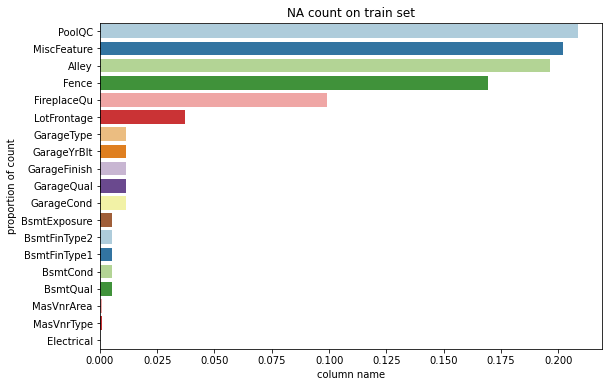

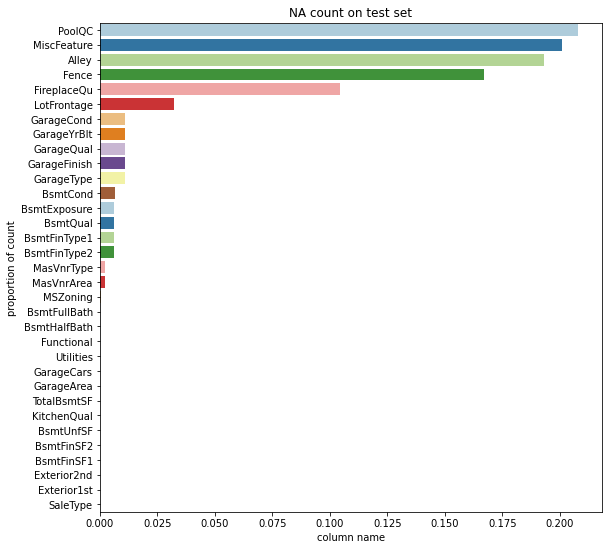

In [8]:
plot_na_count(features, title='NA count on train set')
plot_na_count(X_test_full, figsize=(9,9), title='NA count on test set')

In [9]:
none_list = ['PoolQC', 'MiscFeature', 'Alley', 'Fence', 'FireplaceQu', 'GarageType', 'GarageFinish',
             'GarageQual', 'GarageCond', 'BsmtExposure', 'BsmtFinType2', 'BsmtFinType1', 'BsmtCond',
             'BsmtQual', 'MasVnrType']
zero_list =  ['MasVnrArea', 'BsmtHalfBath', 'BsmtFullBath', 'TotalBsmtSF', 'BsmtFinSF2', 'BsmtFinSF1', 'GarageCars', 'GarageArea', 'BsmtUnfSF']
mode_list = ['Electrical', 'MSZoning', 'Functional', 'Utilities', 'KitchenQual', 'Exterior1st', 'Exterior2nd']
median_list = ['LotFrontage']

# fill empty value according to data description
features.fillna({col: 'None' for col in none_list}, inplace=True)
X_test_full.fillna({col: 'None' for col in none_list}, inplace=True)

features.fillna({col: 0 for col in zero_list}, inplace=True)
X_test_full.fillna({col: 0 for col in zero_list}, inplace=True)

# filling with mode due to unprovided missing value description
features.fillna({col: features[col].mode()[0] for col in mode_list}, inplace=True)
X_test_full.fillna({col: X_test_full[col].mode()[0] for col in mode_list}, inplace=True)

# make missing Sale type = Other
features['SaleType']  = features['SaleType'].fillna('Oth')
X_test_full['SaleType'] = X_test_full['SaleType'].fillna('Oth')

In [10]:
log_target = np.log1p(target) # log transform target for ease of evaluation
log_target_rf = np.log1p(target_rf)

skewness of lot frontage: 2.163569142324884 



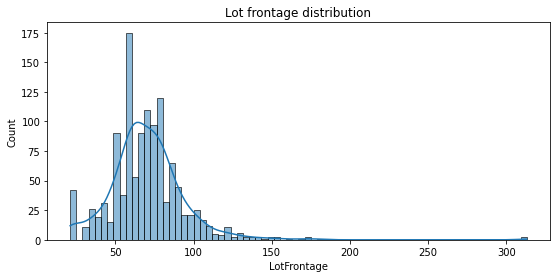

In [11]:
print('skewness of lot frontage:', features['LotFrontage'].skew(), '\n')
plt.figure(figsize=(9,4))
plt.title('Lot frontage distribution')
sns.histplot(features['LotFrontage'], kde=True)
plt.show()

In [12]:
# filling with street group median due to non-normality
features['LotFrontage'] = features.groupby('Street')['LotFrontage'].transform(lambda x: x.fillna(x.median()))
X_test_full['LotFrontage'] = X_test_full.groupby('Street')['LotFrontage'].transform(lambda x: x.fillna(x.median()))

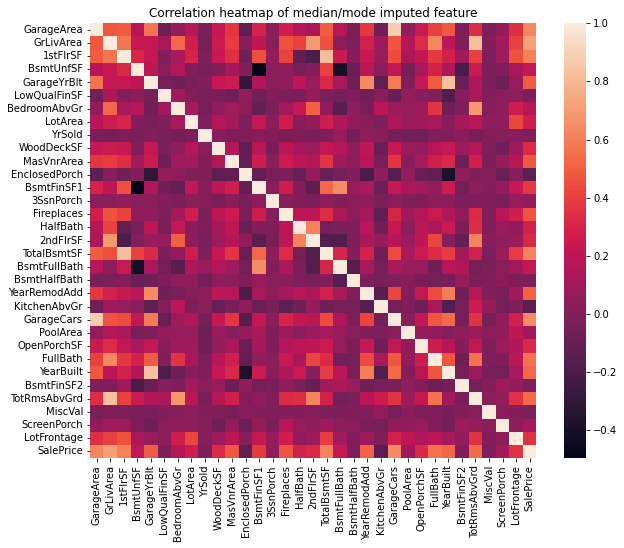

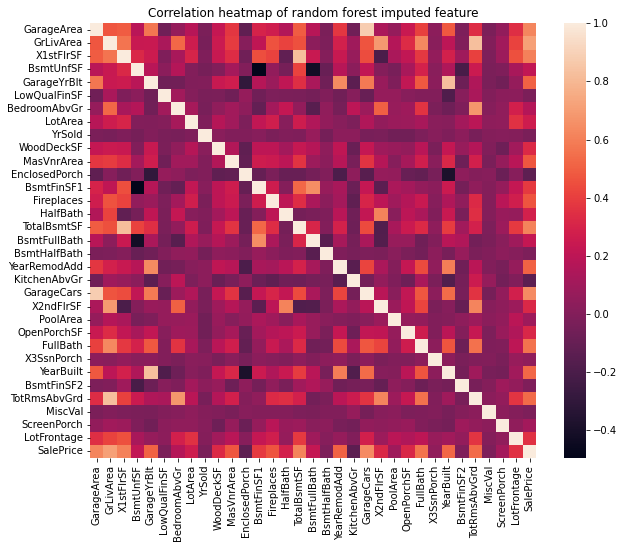

In [13]:
# plot correlation heat map
corr = X[numeric + ['SalePrice']].corr()
corr_rf = X_rf[numeric_rf + ['SalePrice']].corr()

plt.figure(figsize=(10,8))
plt.title('Correlation heatmap of median/mode imputed feature')
sns.heatmap(corr)
plt.show()

plt.figure(figsize=(10,8))
plt.title('Correlation heatmap of random forest imputed feature')
sns.heatmap(corr_rf)
plt.show()

In [14]:
_ = (np.abs(corr) >= 0.7).sum() - 1
display(_[_>0].sort_values(ascending=False))
print('\n')
_ = (np.abs(corr_rf) >= 0.7).sum() - 1
display(_[_>0].sort_values(ascending=False))

GrLivArea       2
GarageArea      1
1stFlrSF        1
GarageYrBlt     1
TotalBsmtSF     1
GarageCars      1
YearBuilt       1
TotRmsAbvGrd    1
SalePrice       1
dtype: int64

GrLivArea       2
GarageArea      1
X1stFlrSF       1
GarageYrBlt     1
TotalBsmtSF     1
GarageCars      1
YearBuilt       1
TotRmsAbvGrd    1
SalePrice       1
dtype: int64

In [15]:
copy = features[numeric].copy()
copy_t = X_test_full[numeric].copy()
copy_rf = features_rf[numeric_rf].copy()
copy_t_rf = X_test_full_rf[numeric_rf].copy()

# drop highly correlated features
for df in [copy, copy_t]:
    df.drop(columns=['1stFlrSF', 'GarageCars', 'BsmtFullBath', 'GarageYrBlt'], inplace=True)
    
for df in [copy_rf, copy_t_rf]:
    df.drop(columns=['X1stFlrSF', 'GarageCars', 'BsmtFullBath', 'GarageYrBlt'], inplace=True)

copy.columns

Index(['GarageArea', 'GrLivArea', 'BsmtUnfSF', 'LowQualFinSF', 'BedroomAbvGr',
       'LotArea', 'YrSold', 'WoodDeckSF', 'MasVnrArea', 'EnclosedPorch',
       'BsmtFinSF1', '3SsnPorch', 'Fireplaces', 'HalfBath', '2ndFlrSF',
       'TotalBsmtSF', 'BsmtHalfBath', 'YearRemodAdd', 'KitchenAbvGr',
       'PoolArea', 'OpenPorchSF', 'FullBath', 'YearBuilt', 'BsmtFinSF2',
       'TotRmsAbvGrd', 'MiscVal', 'ScreenPorch', 'LotFrontage'],
      dtype='object')

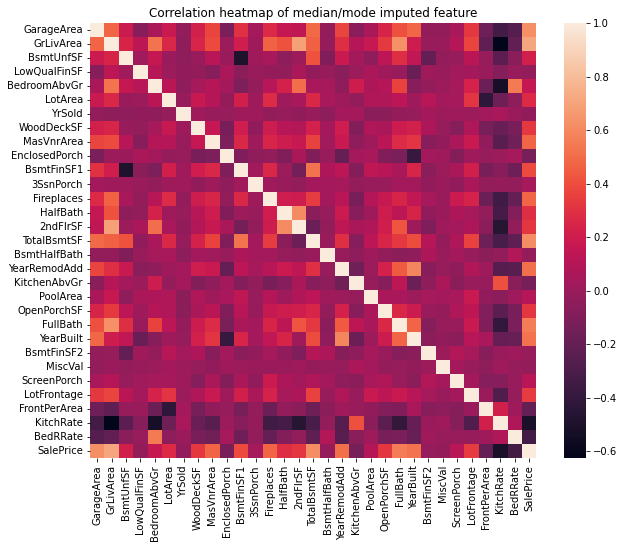

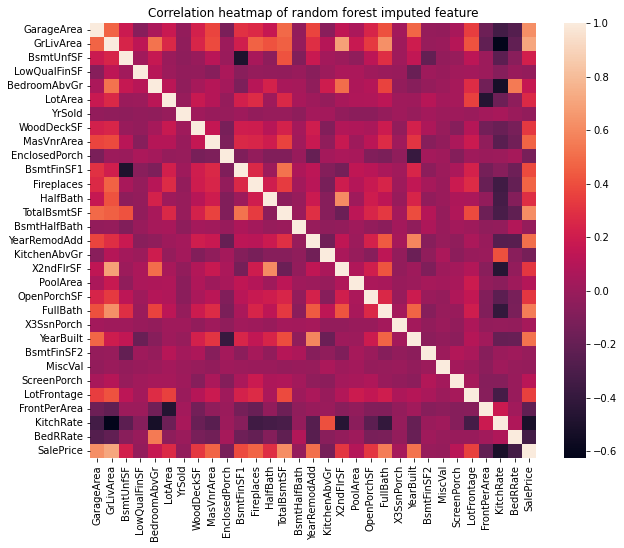

In [16]:
copy['FrontPerArea'] = copy['LotFrontage'] / copy['LotArea']
copy_t['FrontPerArea'] = copy_t['LotFrontage'] / copy_t['LotArea']
copy_rf['FrontPerArea'] = copy_rf['LotFrontage'] / copy_rf['LotArea']
copy_t_rf['FrontPerArea'] = copy_t_rf['LotFrontage'] / copy_t_rf['LotArea']

copy['KitchRate'] = copy['KitchenAbvGr'] / copy['TotRmsAbvGrd']
copy_t['KitchRate'] = copy_t['KitchenAbvGr'] / copy_t['TotRmsAbvGrd']
copy_rf['KitchRate'] = copy_rf['KitchenAbvGr'] / copy_rf['TotRmsAbvGrd']
copy_t_rf['KitchRate'] = copy_t_rf['KitchenAbvGr'] / copy_t_rf['TotRmsAbvGrd']

copy['BedRRate'] = copy['BedroomAbvGr'] / copy['TotRmsAbvGrd']
copy_t['BedRRate'] = copy_t['BedroomAbvGr'] / copy_t['TotRmsAbvGrd']
copy_rf['BedRRate'] = copy_rf['BedroomAbvGr'] / copy_rf['TotRmsAbvGrd']
copy_t_rf['BedRRate'] = copy_t_rf['BedroomAbvGr'] / copy_t_rf['TotRmsAbvGrd']

for df in [copy, copy_t, copy_rf, copy_t_rf]:
    df.drop(columns=['TotRmsAbvGrd'], inplace=True)

plt.figure(figsize=(10,8))
plt.title('Correlation heatmap of median/mode imputed feature')
sns.heatmap(pd.concat([copy, X['SalePrice']], axis=1).corr())
plt.show()
plt.figure(figsize=(10,8))
plt.title('Correlation heatmap of random forest imputed feature')
sns.heatmap(pd.concat([copy_rf, X_rf['SalePrice']], axis=1).corr())
plt.show()

In [17]:
# verify no colinearity
_ = (np.abs(copy.corr()) >= 0.7).sum() - 1
display(_[_>0].sort_values(ascending=False))
print('\n')
_ = (np.abs(copy_rf.corr()) >= 0.7).sum() - 1
display(_[_>0].sort_values(ascending=False))

Series([], dtype: int64)

Series([], dtype: int64)

In [18]:
# encode categorical variable using target group mean
enc = BayesianTargetEncoder(
    columns=nominal,
    prior_weight=5, # smoothing to prevent overfitting
    suffix=''
    )

nom_train = enc.fit_transform(features.loc[:,nominal], log_target)
nom_test = enc.transform(X_test_full.loc[:,nominal])

# encode categorical variable using target group mean
enc_rf = BayesianTargetEncoder(
    columns=nominal_rf,
    prior_weight=5, # smoothing to prevent overfitting
    suffix=''
    )

nom_train_rf = enc_rf.fit_transform(features_rf.loc[:,nominal_rf], log_target_rf)
nom_test_rf = enc_rf.transform(X_test_full_rf.loc[:,nominal_rf])

In [19]:
copy_cat = pd.concat([features[ordinal], nom_train], axis=1)
copy_catt = pd.concat([X_test_full[ordinal], nom_test], axis=1)

copy_cat_rf = pd.concat([features_rf[ordinal_rf], nom_train_rf], axis=1)
copy_catt_rf = pd.concat([X_test_full_rf[ordinal_rf], nom_test_rf], axis=1)

In [20]:
# feature standardization
scaler = StandardScaler()
num_scaled = pd.DataFrame(scaler.fit_transform(copy), index=features.index, columns=copy.columns)
num_scaled_test = pd.DataFrame(scaler.transform(copy_t), index=X_test_full.index, columns=copy.columns)

scaler_rf = StandardScaler()
num_scaled_rf = pd.DataFrame(scaler_rf.fit_transform(copy_rf), index=features_rf.index, columns=copy_rf.columns)
num_scaled_test_rf = pd.DataFrame(scaler_rf.transform(copy_t_rf), index=X_test_full_rf.index, columns=copy_rf.columns)

In [21]:
X_train = pd.concat([num_scaled, copy_cat], axis=1)
X_test = pd.concat([num_scaled_test, copy_catt], axis=1)

X_train_rf = pd.concat([num_scaled_rf, copy_cat_rf], axis=1)
X_test_rf = pd.concat([num_scaled_test_rf, copy_catt_rf], axis=1)

In [22]:
n_splits = 5
def do_cv(X, y, clf):
    means = []
    kf = KFold(n_splits=n_splits, shuffle=True)
    for train_index, test_index in kf.split(X):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        model = clf.fit(X_train, y_train)
        rmsle = mean_squared_error(y_test, model.predict(X_test))
        means.append(rmsle)
    return np.average(means)

In [23]:
def objective_lasso(trial):
    params = dict(
           alpha=trial.suggest_float('alpha', 1e-5, 1e0)
    )
    model = Lasso(**params, max_iter = 10000000)
    return do_cv(X_train, log_target, model)

def objective_lasso_rf(trial):
    params = dict(
           alpha=trial.suggest_float('alpha', 1e-5, 1e0)
    )
    model = Lasso(**params, max_iter = 10000000)
    return do_cv(X_train_rf, log_target_rf, model)

optuna.logging.set_verbosity(optuna.logging.ERROR)
study_lasso = optuna.create_study(direction='minimize')
study_lasso.optimize(objective_lasso, n_trials=150, show_progress_bar=True)

study_lasso_rf = optuna.create_study(direction='minimize')
study_lasso_rf.optimize(objective_lasso_rf, n_trials=150, show_progress_bar=True)

/opt/conda/lib/python3.7/site-packages/optuna/progress_bar.py:47: ExperimentalWarning: Progress bar is experimental (supported from v1.2.0). The interface can change in the future.
  self._init_valid()


  0%|          | 0/150 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/optuna/progress_bar.py:47: ExperimentalWarning: Progress bar is experimental (supported from v1.2.0). The interface can change in the future.
  self._init_valid()


  0%|          | 0/150 [00:00<?, ?it/s]

In [24]:
print('best lasso regression rmsle score:', np.sqrt(study_lasso.best_value))
print('best random forest imputed lasso regression rmsle score:', np.sqrt(study_lasso_rf.best_value))

best lasso regression rmsle score: 0.14349208905052876
best random forest imputed lasso regression rmsle score: 0.14390816020598754


In [25]:
lasso_model = Lasso(**study_lasso_rf.best_params).fit(X_train_rf, log_target_rf)
np.expm1(lasso_model.predict(X_test_rf))

array([122603.5443671 , 152304.69937676, 178051.11841028, ...,
       170668.76008514, 120948.16340714, 214645.32076296])

In [26]:
def objective_ridge(trial):
    params = dict(
           alpha=trial.suggest_float('alpha', 1e-5, 1e0)
    )
    model = Ridge(**params, max_iter = 10000000)
    return do_cv(X_train, log_target, model)

def objective_ridge_rf(trial):
    params = dict(
           alpha=trial.suggest_float('alpha', 1e-5, 1e0)
    )
    model = Ridge(**params, max_iter = 10000000)
    return do_cv(X_train_rf, log_target_rf, model)

optuna.logging.set_verbosity(optuna.logging.ERROR)
study_ridge = optuna.create_study(direction='minimize')
study_ridge.optimize(objective_ridge, n_trials=150, show_progress_bar=True)

study_ridge_rf = optuna.create_study(direction='minimize')
study_ridge_rf.optimize(objective_ridge_rf, n_trials=150, show_progress_bar=True)

/opt/conda/lib/python3.7/site-packages/optuna/progress_bar.py:47: ExperimentalWarning: Progress bar is experimental (supported from v1.2.0). The interface can change in the future.
  self._init_valid()


  0%|          | 0/150 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/optuna/progress_bar.py:47: ExperimentalWarning: Progress bar is experimental (supported from v1.2.0). The interface can change in the future.
  self._init_valid()


  0%|          | 0/150 [00:00<?, ?it/s]

In [27]:
print('best ridge regression rmsle score:', np.sqrt(study_ridge.best_value))
print('best random forest imputed ridge regression rmsle score:', np.sqrt(study_ridge_rf.best_value))

best ridge regression rmsle score: 0.13884428640341656
best random forest imputed ridge regression rmsle score: 0.1404957725078332


In [28]:
ridge_model = Ridge(**study_ridge_rf.best_params).fit(X_train_rf, log_target_rf)
np.expm1(ridge_model.predict(X_test_rf))

array([118700.02246577, 155043.01798003, 175476.51476488, ...,
       168778.68943001, 120100.53445174, 213950.57495481])

In [29]:
def objective_svr(trial):
    params = dict(
            C=trial.suggest_float('C', 1e-2, 1e3)
    )
    model = SVR(**params)
    return do_cv(X_train, log_target, model)

optuna.logging.set_verbosity(optuna.logging.ERROR)
study_svr = optuna.create_study(direction='minimize')
study_svr.optimize(objective_svr, n_trials=150, show_progress_bar=True)

/opt/conda/lib/python3.7/site-packages/optuna/progress_bar.py:47: ExperimentalWarning: Progress bar is experimental (supported from v1.2.0). The interface can change in the future.
  self._init_valid()


  0%|          | 0/150 [00:00<?, ?it/s]

In [30]:
def objective_svr_rf(trial):
    params = dict(
            C=trial.suggest_float('C', 1e-2, 1e3)
    )
    model = SVR(**params)
    return do_cv(X_train_rf, log_target_rf, model)

optuna.logging.set_verbosity(optuna.logging.ERROR)
study_svr_rf = optuna.create_study(direction='minimize')
study_svr_rf.optimize(objective_svr_rf, n_trials=150, show_progress_bar=True)

/opt/conda/lib/python3.7/site-packages/optuna/progress_bar.py:47: ExperimentalWarning: Progress bar is experimental (supported from v1.2.0). The interface can change in the future.
  self._init_valid()


  0%|          | 0/150 [00:00<?, ?it/s]

In [31]:
print('best svr rmsle score:', np.sqrt(study_svr.best_value))
print('best random forest imputed svr rmsle score:', np.sqrt(study_svr_rf.best_value))

best svr rmsle score: 0.12502973066370596
best random forest imputed svr rmsle score: 0.12293771357310194


In [32]:
svr_model = SVR(**study_svr_rf.best_params).fit(X_train_rf, log_target_rf)
np.expm1(svr_model.predict(X_test_rf))

array([115453.11099974, 164748.00327689, 185250.00202732, ...,
       166768.68136388, 115189.15943688, 222367.77428263])

In [33]:
def objective_gdb(trial):
    params = dict(
        n_estimators=trial.suggest_int('n_estimators', 50, 200),
        learning_rate=trial.suggest_float('learning_rate', 5e-2, 3e-1),
        max_depth=trial.suggest_int('max_depth', 2, 6)
    )
    model = GradientBoostingRegressor(**params)
    return do_cv(X_train, log_target, model)

optuna.logging.set_verbosity(optuna.logging.ERROR)
study_gdb = optuna.create_study(direction='minimize')
study_gdb.optimize(objective_gdb, n_trials=75, show_progress_bar=True)

/opt/conda/lib/python3.7/site-packages/optuna/progress_bar.py:47: ExperimentalWarning: Progress bar is experimental (supported from v1.2.0). The interface can change in the future.
  self._init_valid()


  0%|          | 0/75 [00:00<?, ?it/s]

In [34]:
def objective_gdb_rf(trial):
    params = dict(
        n_estimators=trial.suggest_int('n_estimators', 50, 200),
        learning_rate=trial.suggest_float('learning_rate', 5e-2, 3e-1),
        max_depth=trial.suggest_int('max_depth', 2, 6)
    )
    model = GradientBoostingRegressor(**params)
    return do_cv(X_train_rf, log_target_rf, model)
study_gdb_rf = optuna.create_study(direction='minimize')
study_gdb_rf.optimize(objective_gdb_rf, n_trials=75, show_progress_bar=True)

/opt/conda/lib/python3.7/site-packages/optuna/progress_bar.py:47: ExperimentalWarning: Progress bar is experimental (supported from v1.2.0). The interface can change in the future.
  self._init_valid()


  0%|          | 0/75 [00:00<?, ?it/s]

In [35]:
print('best gdb rmsle score:', np.sqrt(study_gdb.best_value))
print('best random forest imputed gdb rmsle score:', np.sqrt(study_gdb_rf.best_value))

best gdb rmsle score: 0.12253613526005011
best random forest imputed gdb rmsle score: 0.1230245465849128


In [36]:
gdb_model = GradientBoostingRegressor(**study_gdb_rf.best_params).fit(X_train_rf, log_target_rf)
np.expm1(gdb_model.predict(X_test_rf))

array([128654.59293561, 160829.080908  , 194779.64276337, ...,
       145261.35059405, 121758.24853912, 206787.75922857])

In [37]:
combined = 0.55 * svr_model.predict(X_test_rf) + 0.45 * gdb_model.predict(X_test_rf)
np.exp(combined)

array([121218.2675128 , 162973.80823265, 189480.2367793 , ...,
       156723.19792374, 118101.20811909, 215217.5625759 ])

In [38]:
pd.DataFrame({
    'Id': X_test_rf.index,
    'SalePrice': np.expm1(combined)
}).to_csv('submission.csv', index=False)

In [39]:
# export models
with open('svr.pkl', 'wb') as fp:
    pickle.dump(svr_model, fp)
    
with open('gdb.pkl', 'wb') as fp:
    pickle.dump(gdb_model, fp)